In [ ]:
from tqdm import tqdm 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xdeepfm
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from xdeepfm import Field

In [ ]:
%load_ext autoreload
%autoreload 2

In [69]:
df = pd.read_csv("./data/ml-100k/u.data", header=None, delim_whitespace=True, encoding='utf-8')
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']

X = df[['user_id', 'item_id']].to_numpy()
y = df['rating'].to_numpy()
y = (y >= 4).astype(int)

batch_size = 2048

num_users = np.max(df['user_id']).item() + 1
num_items = np.max(df['item_id']).item() + 1
fields = [num_users, num_items]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5)
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_X),
        torch.tensor(train_y).float(),
    ),
    batch_size=batch_size,
    drop_last=True
)
test_dl = DataLoader(
    TensorDataset(
        torch.tensor(test_X),
        torch.tensor(test_y).float(),
    ),
    batch_size=batch_size,
    drop_last=True
)

def evaluate_net(net, loss_fn, flatten_y=True):
    net.cuda()
    net.eval()
    total_loss = 0.0
    predictions = []
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_dl, desc="Evaluating"):
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            if not flatten_y:
                batch_y = batch_y.unsqueeze(-1)
            else:
                batch_y = batch_y.flatten()
            predicted_ratings = net(batch_x)
            loss = loss_fn(predicted_ratings, batch_y)
            total_loss += loss.item()
            predictions.extend(predicted_ratings.cpu().numpy())
    avg_loss = total_loss / len(test_dl)
    print(f"Average Loss: {avg_loss:.4f}")
    return avg_loss

def fit(net, loss_fn, epochs=10, lr=0.001, flatten_y=True):
    net.train()
    optim = torch.optim.Adam(net.parameters(), lr)
    J = []  
    for e in tqdm(range(epochs)):
        for batch_x, batch_y in tqdm(train_dl):
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            optim.zero_grad()
            if not flatten_y:
                batch_y = batch_y.unsqueeze(-1)
            else:
                batch_y = batch_y.flatten()
            out = net(batch_x)
            loss = loss_fn(out, batch_y)
            loss.backward()
            optim.step()
            J.append(loss)
        evaluate_net(net, loss_fn, flatten_y)
        net.train()
        print(f"Epoch {e + 1}/{epochs}: Loss {loss:.2f}")
    return J

# Our model

In [ ]:
config = xdeepfm.NetConfig(fields=fields, m=2, dnn=xdeepfm.DNNConfig(), cin=xdeepfm.CINConfig())
net = xdeepfm.xDeepFM(config=config).cuda()

In [70]:
my_J = fit(net, torch.nn.BCELoss(), epochs=10, flatten_y=False)

 10%|█         | 1/10 [00:01<00:14,  1.60s/it]

Average Loss: 0.6975
Epoch 1/10: Loss 0.70


 20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Average Loss: 0.6861
Epoch 2/10: Loss 0.68


 30%|███       | 3/10 [00:04<00:11,  1.60s/it]

Average Loss: 0.6760
Epoch 3/10: Loss 0.67


 40%|████      | 4/10 [00:06<00:09,  1.61s/it]

Average Loss: 0.6667
Epoch 4/10: Loss 0.65


 50%|█████     | 5/10 [00:08<00:08,  1.62s/it]

Average Loss: 0.6591
Epoch 5/10: Loss 0.64


 60%|██████    | 6/10 [00:09<00:06,  1.64s/it]

Average Loss: 0.6516
Epoch 6/10: Loss 0.63


 70%|███████   | 7/10 [00:11<00:05,  1.71s/it]

Average Loss: 0.6445
Epoch 7/10: Loss 0.61


 70%|███████   | 7/10 [00:12<00:05,  1.73s/it]


KeyboardInterrupt: 

# Official implementation

In [47]:
from torchfm.model.xdfm import ExtremeDeepFactorizationMachineModel

In [56]:
official_xdfm = ExtremeDeepFactorizationMachineModel(fields, embed_dim=10, cross_layer_sizes=(100, 100, 100), split_half=False, mlp_dims=(100, 100, 100), dropout=0).cuda()

In [59]:
real_J = fit(official_xdfm, torch.nn.BCELoss(), epochs=10)

 10%|█         | 1/10 [00:01<00:11,  1.28s/it]

Average Loss: 0.9338
Epoch 1/10: Loss 0.63


 20%|██        | 2/10 [00:02<00:10,  1.30s/it]

Average Loss: 0.7035
Epoch 2/10: Loss 0.56


 30%|███       | 3/10 [00:03<00:08,  1.26s/it]

Average Loss: 0.5959
Epoch 3/10: Loss 0.53


 40%|████      | 4/10 [00:05<00:07,  1.24s/it]

Average Loss: 0.6043
Epoch 4/10: Loss 0.50


 50%|█████     | 5/10 [00:06<00:06,  1.29s/it]

Average Loss: 0.6186
Epoch 5/10: Loss 0.48


 60%|██████    | 6/10 [00:07<00:05,  1.26s/it]

Average Loss: 0.6386
Epoch 6/10: Loss 0.46


 70%|███████   | 7/10 [00:08<00:03,  1.29s/it]

Average Loss: 0.6597
Epoch 7/10: Loss 0.43


 80%|████████  | 8/10 [00:10<00:02,  1.27s/it]

Average Loss: 0.6881
Epoch 8/10: Loss 0.40


 90%|█████████ | 9/10 [00:11<00:01,  1.25s/it]

Average Loss: 0.7252
Epoch 9/10: Loss 0.38


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]

Average Loss: 0.7581
Epoch 10/10: Loss 0.36


<Axes: >

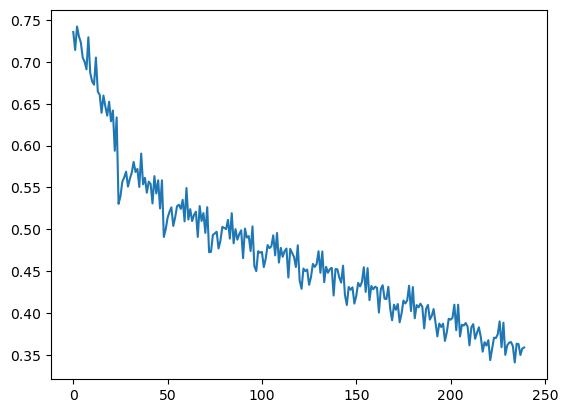

In [68]:
sns.lineplot([float(j.cpu()) for j in real_J])